In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from random import uniform
import numpy as np
from numpy import pi
import swarms
from random import randint, seed, uniform

from swarms import MMOON, MJUP, RJUP, AU, REARTH, MEARTH, PC, MSUN, LSUN, YEAR, MICRON, KM

In [3]:
def loguniform(minval, maxval):
    return 10**uniform(np.log10(minval), np.log10(maxval))

def Mbol_to_L(M):
    return 10**(0.4*(4.74-M))

def distance_sampler(mean, std):
    s = 0
    while s <= 0:
        s = random.normal(loc=mean, scale=std)
    return s

def draw_planet(star, age, a, IWA=0.2, OWA=1.2):
    Mmin = 21 # Mearth (Nep)
    Mmax = 5*318 # Mearth (Jup)
    # Draw mass from Nep to 13 Mjup according to m^-0.86 Clanton 16
    totoccurrence = 1.
    Npts = 1000
    alpha = -0.86
    Q = 0.5 # planet albedo
    ms = np.linspace(Mmin, Mmax, Npts)
    pdf = ms**(alpha-1) # dN/dlogM = dN/dM * m, so dN/dM \propto m^(alpha-1)
    cumpdf = np.cumsum(pdf)/pdf.sum() * totoccurrence
    randv = np.random.uniform()
    idx = np.searchsorted(cumpdf, randv)
    if idx == len(cumpdf):
        return None # didn't draw a planet
    else:
        #print("a in notebook: {0:.3e}".format(a))
        return swarms.Planet(star, M=ms[idx]*MEARTH , R=None, a=a, Q=Q, Z='002', age=age)

In [3]:
def aoptChar(Lstar, Mstar, Tstar, Mtot, tage, dpl, a):
    star = swarms.Star(Lstar, Mstar, Tstar, d=dpl)
    planet = draw_planet(star, tage, a)
    if planet is None:
        return aoptChar(Mstar, Mtot, tage, dapl) # do it again
    Dc = loguniform(1e4, 1e6) # m
    rho = 1000 # kg/m^3
    eta = 0.3 # eta
    Dt = loguniform(10, 1000) # m
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    f_vrel = 4./pi
    a_opt = aopt11(star, Mtot, 1e6*YEAR, planet, Dt, Nstr, fQ, Dc, rho, eta, charFactor=1., f_vrel=4./pi)
    star.d = a_opt/(AU*0.7)*PC
    return a_opt

In [3]:
def aopt11(star, Mtot, age, planet, Dt, Nstr, fQ, Dc, rho, eta, charFactor=1., f_vrel=4./pi):
    return AU * charFactor * 65. * (fQ/5.)**0.15 * (eta/0.3)**(-1.) * (rho/1000.)**(-0.39) * (Dc/(KM * 100.))**(-0.43) * (planet.M/MJUP)**(-0.06) * (star.M/MSUN)**0.33 * (age/(1e6*YEAR))**0.24 * (Mtot/MEARTH)**0.24  

In [4]:
# Set up 23 star types from A0 to M4
# Ls in Lsun
# Ts in Kelvin
# Ms in Msun
Mags = [1.24, 1.64, 1.95, 2.28, 2.61, 2.95, 3.27, 3.58, 3.86, 4.12, 4.33, 4.54, 4.71, 4.9, 5.09, 5.31, 5.62, 6.02, 6.44, 6.88, 7.55, 8.69, 10.14]
Ts = [9700, 9040, 8620, 8200, 7800, 7420, 7040, 6690, 6400, 6150, 5950, 5770, 5640, 5510, 5370, 5200, 4930, 4590, 4260, 3990, 3700, 3400, 3100]
Ms = [2.07, 1.94, 1.79, 1.66, 1.53, 1.4, 1.31, 1.23, 1.16, 1.09, 1.04, 0.986, 0.933, 0.879, 0.829, 0.781, 0.738, 0.693, 0.647, 0.585, 0.454, 0.262, 0.124]

Ls = [Mbol_to_L(Mags[i]) for i in range(len(Mags))]
M0 = 1.*MEARTH
age = 30e6*YEAR
apl = np.logspace(0, 2.5, 23)

In [5]:
# Convert all arrays into SI
Ls = np.array(Ls)*LSUN
Ms = np.array(Ms)*MSUN
dpl = np.array(apl)/0.7
dpl = dpl*PC
apl = apl*AU

In [6]:
# create the mesh
TS, APL = np.meshgrid(Ts, apl)
LS, APL = np.meshgrid(Ls, apl)
MS, APL = np.meshgrid(Ms, apl)

print(MS[0])
print(APL[10]/AU)
print(apl)

[4.11930e+30 3.86060e+30 3.56210e+30 3.30340e+30 3.04470e+30 2.78600e+30
 2.60690e+30 2.44770e+30 2.30840e+30 2.16910e+30 2.06960e+30 1.96214e+30
 1.85667e+30 1.74921e+30 1.64971e+30 1.55419e+30 1.46862e+30 1.37907e+30
 1.28753e+30 1.16415e+30 9.03460e+29 5.21380e+29 2.46760e+29]
[13.6887451 13.6887451 13.6887451 13.6887451 13.6887451 13.6887451
 13.6887451 13.6887451 13.6887451 13.6887451 13.6887451 13.6887451
 13.6887451 13.6887451 13.6887451 13.6887451 13.6887451 13.6887451
 13.6887451 13.6887451 13.6887451 13.6887451 13.6887451]
[1.49600000e+11 1.94342577e+11 2.52466826e+11 3.27974957e+11
 4.26066166e+11 5.53494630e+11 7.19034577e+11 9.34084443e+11
 1.21345172e+12 1.57637256e+12 2.04783627e+12 2.66030600e+12
 3.45595403e+12 4.48956559e+12 5.83231114e+12 7.57664690e+12
 9.84268104e+12 1.27864438e+13 1.66106313e+13 2.15785621e+13
 2.80323086e+13 3.64162507e+13 4.73076738e+13]


In [8]:
AOPT = aoptChar(LS, MS, TS, M0, age, DPL, APL)

In [9]:
MSIMAG = []
IMAGREAL = []
DPLIMAG = []
AOPTIMAG = []
for i in range(len(IMAG)):
    temp_MS = []
    temp_IMAG = []
    temp_DPL = []
    temp_AOPT = []
    for j in range(len(IMAG)):
        if not (np.isnan(IMAG[i][j]) or np.isinf(IMAG[i][j])):
            temp_AOPT.append(AOPT[i][j])
            temp_IMAG.append(IMAG[i][j])
            temp_MS.append(MS[i][j])
            temp_DPL.append(DPL[i][j])
    MSIMAG.append(temp_MS)
    IMAGREAL.append(temp_IMAG)
    DPLIMAG.append(temp_DPL)
    AOPTIMAG.append(temp_AOPT)
    
MSIMAG = np.array(MSIMAG)
IMAGREAL = np.array(IMAGREAL)
DPLIMAG = np.array(DPLIMAG)
AOPTIMAG = np.array(AOPTIMAG)

NameError: name 'IMAG' is not defined

In [ ]:
print(IMAGREAL[3])
print(AOPTIMAG[3]/AU)
print(MSIMAG[3]/MSUN)

In [ ]:
# plot contour map
fig, ax = plt.subplots()
#CS = ax.contour(DPL/PC, MS/MSUN, AOPT/AU, colors='r')
CS2 = ax.contour(AOPTIMAG/AU, MSIMAG/MSUN, IMAGREAL, colors='b')
#ax.clabel(CS, inline=1, fontsize=10, fmt='%1i')
ax.clabel(CS2, inline=1, fontsize=10, fmt='%1i')
#ax.set_ylim([-5.2, 1])
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_title('Hard code equation')

In [7]:
def sample():
    Dc = loguniform(1e4, 1e6) # m
    rho = 1000 # kg/m^3
    eta = 0.3 # eta
    Q = loguniform(0.05, 0.25) # Q_bd = [0, 0.8]
    g = loguniform(0.2, 0.8) # 0.32 https://arxiv.org/pdf/1709.00417.pdf
    Dt = loguniform(10, 1000) # m
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    
    return Dc, rho, eta, Q, g, Dt, Nstr, Dmax, fQ

In [8]:
def findAopt(Lstar, Mstar, Tstar, dpl, Dc, rho, eta, Q, g, Dt, Nstr, Dmax, fQ, age, a):
    star = swarms.Star(Lstar, Mstar, Tstar, d=0)
    planet = swarms.Planet(star, M=318*MEARTH , R=None, a=a, Q=Q, Z='002', age=age)
    swarm = swarms.CollSwarm(star, planet, M0, Dt, Dmax, Q=Q, eta=eta, Nstr=Nstr, 
                        rho=rho, fQ=fQ, correction=True, Dmin_min=lamb, age=age)
    
    #a_opt = swarm.computeaopt(t=age)
    star.d = a/(AU*0.7)*PC
    return star.Imag, swarm.computeCRscat(g)

In [9]:
AOPT = np.zeros((len(TS), len(TS[0])))
IMAG = np.zeros((len(TS), len(TS[0])))
CRSCAT = np.zeros((len(TS), len(TS[0])))

Dc, rho, eta, Q, g, Dt, Nstr, Dmax, fQ = sample()
M0 = 1.*MEARTH
age = 30e6*YEAR
lamb = 1.*MICRON

In [10]:
for i in range(len(TS)):
    for j in range(len(TS[0])):
        IMAG[i][j], CRSCAT[i][j] = findAopt(LS[i][j], MS[i][j], TS[i][j], APL[i][j]/(AU*0.7)*PC, Dc, rho, eta, Q, g, Dt, Nstr, Dmax, fQ, age, APL[i][j])
        print('computing IMAG:{4:.3e} with \t LS:{0:.3e} \t MS:{1:.3e} \t TS:{2:.3e} \t APL:{3:.3e}'.format(LS[i][j]/LSUN, MS[i][j]/MSUN, TS[i][j], APL[i][j]/AU, IMAG[i][j]))
    print('------------------------------------------------------------------------------------------------')

C:\Users\loloynage\Documents\CE-Irregular-Satellites\jupyter_examples\swarms.py:257: RuntimeWarning: invalid value encountered in log10
  return -2.5*log10(F/F0)


computing IMAG:nan with 	 LS:2.512e+01 	 MS:2.070e+00 	 TS:9.700e+03 	 APL:1.000e+00
computing IMAG:nan with 	 LS:1.738e+01 	 MS:1.940e+00 	 TS:9.040e+03 	 APL:1.000e+00
computing IMAG:-1.845e+01 with 	 LS:1.306e+01 	 MS:1.790e+00 	 TS:8.620e+03 	 APL:1.000e+00
computing IMAG:-2.321e+01 with 	 LS:9.638e+00 	 MS:1.660e+00 	 TS:8.200e+03 	 APL:1.000e+00
computing IMAG:nan with 	 LS:7.112e+00 	 MS:1.530e+00 	 TS:7.800e+03 	 APL:1.000e+00
computing IMAG:nan with 	 LS:5.200e+00 	 MS:1.400e+00 	 TS:7.420e+03 	 APL:1.000e+00
computing IMAG:-1.877e+01 with 	 LS:3.873e+00 	 MS:1.310e+00 	 TS:7.040e+03 	 APL:1.000e+00
computing IMAG:-1.883e+01 with 	 LS:2.911e+00 	 MS:1.230e+00 	 TS:6.690e+03 	 APL:1.000e+00


C:\Users\loloynage\Documents\CE-Irregular-Satellites\jupyter_examples\swarms.py:273: RuntimeWarning: divide by zero encountered in double_scalars
  return self.L/SIG/self.T**4


computing IMAG:-inf with 	 LS:2.249e+00 	 MS:1.160e+00 	 TS:6.400e+03 	 APL:1.000e+00
computing IMAG:nan with 	 LS:1.770e+00 	 MS:1.090e+00 	 TS:6.150e+03 	 APL:1.000e+00
computing IMAG:-1.561e+01 with 	 LS:1.459e+00 	 MS:1.040e+00 	 TS:5.950e+03 	 APL:1.000e+00
computing IMAG:-1.461e+01 with 	 LS:1.202e+00 	 MS:9.860e-01 	 TS:5.770e+03 	 APL:1.000e+00
computing IMAG:nan with 	 LS:1.028e+00 	 MS:9.330e-01 	 TS:5.640e+03 	 APL:1.000e+00
computing IMAG:-1.458e+01 with 	 LS:8.630e-01 	 MS:8.790e-01 	 TS:5.510e+03 	 APL:1.000e+00
computing IMAG:-1.460e+01 with 	 LS:7.244e-01 	 MS:8.290e-01 	 TS:5.370e+03 	 APL:1.000e+00
computing IMAG:nan with 	 LS:5.916e-01 	 MS:7.810e-01 	 TS:5.200e+03 	 APL:1.000e+00
computing IMAG:nan with 	 LS:4.446e-01 	 MS:7.380e-01 	 TS:4.930e+03 	 APL:1.000e+00
computing IMAG:-1.263e+01 with 	 LS:3.076e-01 	 MS:6.930e-01 	 TS:4.590e+03 	 APL:1.000e+00
computing IMAG:-1.177e+01 with 	 LS:2.089e-01 	 MS:6.470e-01 	 TS:4.260e+03 	 APL:1.000e+00
computing IMAG:nan wit

computing IMAG:nan with 	 LS:5.200e+00 	 MS:1.400e+00 	 TS:7.420e+03 	 APL:2.848e+00
computing IMAG:-1.650e+01 with 	 LS:3.873e+00 	 MS:1.310e+00 	 TS:7.040e+03 	 APL:2.848e+00
computing IMAG:-1.656e+01 with 	 LS:2.911e+00 	 MS:1.230e+00 	 TS:6.690e+03 	 APL:2.848e+00
computing IMAG:-inf with 	 LS:2.249e+00 	 MS:1.160e+00 	 TS:6.400e+03 	 APL:2.848e+00
computing IMAG:nan with 	 LS:1.770e+00 	 MS:1.090e+00 	 TS:6.150e+03 	 APL:2.848e+00
computing IMAG:-1.333e+01 with 	 LS:1.459e+00 	 MS:1.040e+00 	 TS:5.950e+03 	 APL:2.848e+00
computing IMAG:-1.234e+01 with 	 LS:1.202e+00 	 MS:9.860e-01 	 TS:5.770e+03 	 APL:2.848e+00
computing IMAG:nan with 	 LS:1.028e+00 	 MS:9.330e-01 	 TS:5.640e+03 	 APL:2.848e+00
computing IMAG:-1.231e+01 with 	 LS:8.630e-01 	 MS:8.790e-01 	 TS:5.510e+03 	 APL:2.848e+00
computing IMAG:-1.232e+01 with 	 LS:7.244e-01 	 MS:8.290e-01 	 TS:5.370e+03 	 APL:2.848e+00
computing IMAG:nan with 	 LS:5.916e-01 	 MS:7.810e-01 	 TS:5.200e+03 	 APL:2.848e+00
computing IMAG:nan wit

computing IMAG:-1.866e+01 with 	 LS:9.638e+00 	 MS:1.660e+00 	 TS:8.200e+03 	 APL:8.111e+00
computing IMAG:nan with 	 LS:7.112e+00 	 MS:1.530e+00 	 TS:7.800e+03 	 APL:8.111e+00
computing IMAG:nan with 	 LS:5.200e+00 	 MS:1.400e+00 	 TS:7.420e+03 	 APL:8.111e+00
computing IMAG:-1.422e+01 with 	 LS:3.873e+00 	 MS:1.310e+00 	 TS:7.040e+03 	 APL:8.111e+00
computing IMAG:-1.429e+01 with 	 LS:2.911e+00 	 MS:1.230e+00 	 TS:6.690e+03 	 APL:8.111e+00
computing IMAG:-inf with 	 LS:2.249e+00 	 MS:1.160e+00 	 TS:6.400e+03 	 APL:8.111e+00
computing IMAG:nan with 	 LS:1.770e+00 	 MS:1.090e+00 	 TS:6.150e+03 	 APL:8.111e+00
computing IMAG:-1.106e+01 with 	 LS:1.459e+00 	 MS:1.040e+00 	 TS:5.950e+03 	 APL:8.111e+00
computing IMAG:-1.007e+01 with 	 LS:1.202e+00 	 MS:9.860e-01 	 TS:5.770e+03 	 APL:8.111e+00
computing IMAG:nan with 	 LS:1.028e+00 	 MS:9.330e-01 	 TS:5.640e+03 	 APL:8.111e+00
computing IMAG:-1.003e+01 with 	 LS:8.630e-01 	 MS:8.790e-01 	 TS:5.510e+03 	 APL:8.111e+00
computing IMAG:-1.005e

computing IMAG:nan with 	 LS:1.738e+01 	 MS:1.940e+00 	 TS:9.040e+03 	 APL:2.310e+01
computing IMAG:-1.163e+01 with 	 LS:1.306e+01 	 MS:1.790e+00 	 TS:8.620e+03 	 APL:2.310e+01
computing IMAG:-1.639e+01 with 	 LS:9.638e+00 	 MS:1.660e+00 	 TS:8.200e+03 	 APL:2.310e+01
computing IMAG:nan with 	 LS:7.112e+00 	 MS:1.530e+00 	 TS:7.800e+03 	 APL:2.310e+01
computing IMAG:nan with 	 LS:5.200e+00 	 MS:1.400e+00 	 TS:7.420e+03 	 APL:2.310e+01
computing IMAG:-1.195e+01 with 	 LS:3.873e+00 	 MS:1.310e+00 	 TS:7.040e+03 	 APL:2.310e+01
computing IMAG:-1.201e+01 with 	 LS:2.911e+00 	 MS:1.230e+00 	 TS:6.690e+03 	 APL:2.310e+01
computing IMAG:-inf with 	 LS:2.249e+00 	 MS:1.160e+00 	 TS:6.400e+03 	 APL:2.310e+01
computing IMAG:nan with 	 LS:1.770e+00 	 MS:1.090e+00 	 TS:6.150e+03 	 APL:2.310e+01
computing IMAG:-8.789e+00 with 	 LS:1.459e+00 	 MS:1.040e+00 	 TS:5.950e+03 	 APL:2.310e+01
computing IMAG:-7.795e+00 with 	 LS:1.202e+00 	 MS:9.860e-01 	 TS:5.770e+03 	 APL:2.310e+01
computing IMAG:nan wit

computing IMAG:2.287e+00 with 	 LS:6.918e-03 	 MS:1.240e-01 	 TS:3.100e+03 	 APL:5.065e+01
------------------------------------------------------------------------------------------------
computing IMAG:nan with 	 LS:2.512e+01 	 MS:2.070e+00 	 TS:9.700e+03 	 APL:6.579e+01
computing IMAG:nan with 	 LS:1.738e+01 	 MS:1.940e+00 	 TS:9.040e+03 	 APL:6.579e+01
computing IMAG:-9.359e+00 with 	 LS:1.306e+01 	 MS:1.790e+00 	 TS:8.620e+03 	 APL:6.579e+01
computing IMAG:-1.412e+01 with 	 LS:9.638e+00 	 MS:1.660e+00 	 TS:8.200e+03 	 APL:6.579e+01
computing IMAG:nan with 	 LS:7.112e+00 	 MS:1.530e+00 	 TS:7.800e+03 	 APL:6.579e+01
computing IMAG:nan with 	 LS:5.200e+00 	 MS:1.400e+00 	 TS:7.420e+03 	 APL:6.579e+01
computing IMAG:-9.679e+00 with 	 LS:3.873e+00 	 MS:1.310e+00 	 TS:7.040e+03 	 APL:6.579e+01
computing IMAG:-9.740e+00 with 	 LS:2.911e+00 	 MS:1.230e+00 	 TS:6.690e+03 	 APL:6.579e+01
computing IMAG:-inf with 	 LS:2.249e+00 	 MS:1.160e+00 	 TS:6.400e+03 	 APL:6.579e+01
computing IMAG:nan

computing IMAG:2.399e-01 with 	 LS:7.516e-02 	 MS:4.540e-01 	 TS:3.700e+03 	 APL:1.442e+02
computing IMAG:nan with 	 LS:2.630e-02 	 MS:2.620e-01 	 TS:3.400e+03 	 APL:1.442e+02
computing IMAG:4.560e+00 with 	 LS:6.918e-03 	 MS:1.240e-01 	 TS:3.100e+03 	 APL:1.442e+02
------------------------------------------------------------------------------------------------
computing IMAG:nan with 	 LS:2.512e+01 	 MS:2.070e+00 	 TS:9.700e+03 	 APL:1.874e+02
computing IMAG:nan with 	 LS:1.738e+01 	 MS:1.940e+00 	 TS:9.040e+03 	 APL:1.874e+02
computing IMAG:-7.086e+00 with 	 LS:1.306e+01 	 MS:1.790e+00 	 TS:8.620e+03 	 APL:1.874e+02
computing IMAG:-1.184e+01 with 	 LS:9.638e+00 	 MS:1.660e+00 	 TS:8.200e+03 	 APL:1.874e+02
computing IMAG:nan with 	 LS:7.112e+00 	 MS:1.530e+00 	 TS:7.800e+03 	 APL:1.874e+02
computing IMAG:nan with 	 LS:5.200e+00 	 MS:1.400e+00 	 TS:7.420e+03 	 APL:1.874e+02
computing IMAG:-7.406e+00 with 	 LS:3.873e+00 	 MS:1.310e+00 	 TS:7.040e+03 	 APL:1.874e+02
computing IMAG:-7.46

In [11]:
MSIMAG = []
IMAGREAL = []
DPLIMAG = []
AOPTIMAG = []
for i in range(len(IMAG)):
    temp_MS = []
    temp_IMAG = []
    temp_DPL = []
    temp_AOPT = []
    for j in range(len(IMAG)):
        if not (np.isnan(IMAG[i][j]) or np.isinf(IMAG[i][j])):
            temp_AOPT.append(APL[i][j])
            temp_IMAG.append(IMAG[i][j])
            temp_MS.append(MS[i][j])
            #temp_DPL.append(DPL[i][j])
    MSIMAG.append(temp_MS)
    IMAGREAL.append(temp_IMAG)
    #DPLIMAG.append(temp_DPL)
    AOPTIMAG.append(temp_AOPT)
    
MSIMAG = np.array(MSIMAG)
IMAGREAL = np.array(IMAGREAL)
#DPLIMAG = np.array(DPLIMAG)
AOPTIMAG = np.array(AOPTIMAG)

In [12]:
print(CRSCAT/1e-7)

[[3.20173725e-08 4.70051355e-08 6.71227956e-08 9.61376045e-08
  1.39343279e-07 2.06140016e-07 2.88250193e-07 3.97800158e-07
  5.33849693e-07 7.12238379e-07 8.93195709e-07 1.13398163e-06
  1.40821846e-06 1.78641728e-06 2.26141764e-06 2.92452529e-06
  3.98445200e-06 5.82256469e-06 8.71459643e-06 1.40514938e-05
  3.52160792e-05 2.08610030e-04 2.08726485e-03]
 [1.25000420e-07 1.83412638e-07 2.61713837e-07 3.74549501e-07
  5.42366404e-07 8.01437065e-07 1.11959578e-06 1.54357111e-06
  2.06941094e-06 2.75773833e-06 3.45515995e-06 4.38161372e-06
  5.43435435e-06 6.88365764e-06 8.70030845e-06 1.12319867e-05
  1.52755544e-05 2.22747313e-05 3.32534353e-05 5.33937515e-05
  1.32035963e-04 7.44287683e-04 6.41573598e-03]
 [4.82559304e-07 7.06929997e-07 1.00653839e-06 1.43724731e-06
  2.07556606e-06 3.05686108e-06 4.25867845e-06 5.85474393e-06
  7.82683732e-06 1.03959551e-05 1.29903837e-05 1.64204248e-05
  2.02925782e-05 2.55972594e-05 3.22095285e-05 4.13800934e-05
  5.59975298e-05 8.11692833e-05 1.20

Text(0.5,0,'aopt [au]')

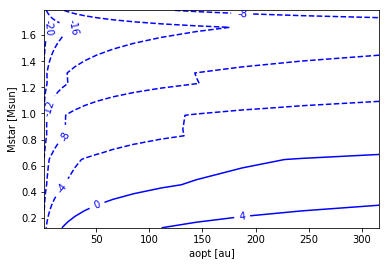

In [13]:
# plot contour map
fig, ax = plt.subplots()
#CS = ax.contour(APL/AU, MS/MSUN, CRSCAT/1e-7, colors='r')
CS2 = ax.contour(AOPTIMAG/AU, MSIMAG/MSUN, IMAGREAL, colors='b')
#ax.clabel(CS, inline=1, fontsize=10, fmt='%1i')
ax.clabel(CS2, inline=1, fontsize=10, fmt='%1i')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylabel('Mstar [Msun]')
ax.set_xlabel('aopt [au]')

Text(0.5,0,'aopt [au]')

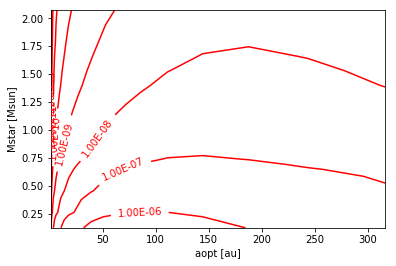

In [14]:
# plot contour map
from matplotlib import ticker, cm
fig, ax = plt.subplots()
CS = ax.contour(APL/AU, MS/MSUN, CRSCAT,locator=ticker.LogLocator(), colors='r')
ax.clabel(CS, inline=1, fontsize=10, fmt='%.2E')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylabel('Mstar [Msun]')
ax.set_xlabel('aopt [au]')

In [ ]:
def aoptimal(A, Mtot, Mstar):
    return (Mtot/MEARTH)*(1/A)*(1/(Mstar/MSUN)**(-1.38))**(1./4.13) * 30 * AU

In [ ]:
def computeA(fQ, eta, rho, Dc, Mpl):
    return 0.04 * (fQ / 5.)**-0.63 * (eta/0.3)**4.13 * (rho/1000.)**1.63 * (Dc/(100*KM))**1.79 * (Mpl/MJUP)**0.24 

In [19]:
#IMAG = np.zeros((len(TS), len(TS[0])))
mAOPT = np.zeros(len(MS[0]))
mIMAG = np.zeros(len(MS[0]))
mDPL = np.zeros(len(MS[0]))

Dc, rho, eta, Q, g, Dt, Nstr, Dmax, fQ = sample()
Mpl = 318.*MEARTH
M0 = 1.*MEARTH
age = 30e6*YEAR
lamb = 1.*MICRON

In [20]:
A = computeA(fQ, eta, rho, Dc, Mpl)
for i in range(len(MS[0])):
    star = swarms.Star(LS[0][i], MS[0][i], TS[0][i], d=DPL[i][0])
    mIMAG[i] = star.Imag 
    mDPL[i] = DPL[i][0]
    mAOPT[i] = aoptimal(A, M0, MS[0][i])

Text(0,0.5,'Mstar [Msun]')

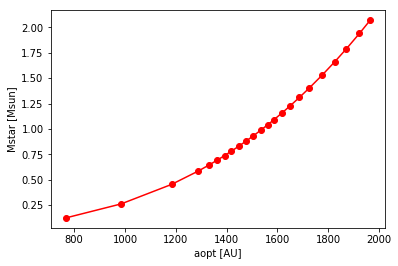

In [21]:
plt.figure()
plt.plot(mAOPT/AU, MS[0]/MSUN, 'ro-')
plt.xlabel('aopt [AU]')
plt.ylabel('Mstar [Msun]')

Text(0,0.5,'Imag')

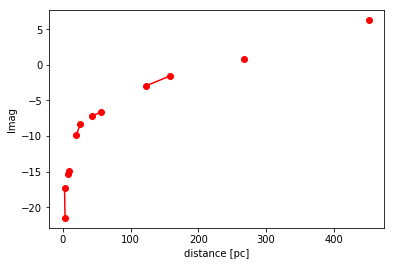

In [22]:
plt.figure()
plt.plot(mDPL/PC, mIMAG, 'ro-')
plt.xlabel('distance [pc]')
plt.ylabel('Imag')

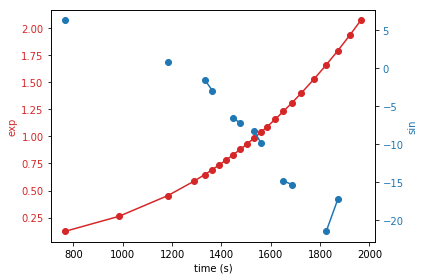

In [33]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(mAOPT/AU, MS[0]/MSUN, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_xlabel('hue', color=color)
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(mAOPT/AU, mIMAG, 'o-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [34]:
print(mIMAG)

[         nan          nan -17.3135065  -21.50261716          nan
          nan -15.36093739 -14.85396113         -inf          nan
  -9.92525899  -8.36302878          nan  -7.19139847  -6.64246466
          nan          nan  -2.97187523  -1.53971873          nan
   0.80810752          nan   6.26414657]
